<a href="https://colab.research.google.com/github/elianasv/HNC_PREDICTION/blob/main/FeatureSelection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This code performs feature selection using the Spearman Correlation matrix and Random Survival Forest as feature selector in the whole dataset**

Libraries downloading

In [1]:
!pip install --upgrade scikit-learn

In [2]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 11.1 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=ac3181bcb9102b40c645862ff0c3f486feb3b63a779122a8f9e5a41b03654152
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [3]:
!pip install scikit-survival

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 39.4 MB/s eta 0:00:00


Libraries importing

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lifelines
from sksurv.ensemble import RandomSurvivalForest
from sklearn.inspection import permutation_importance

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#Set the path of the folder in drive to save the generated datasets and outputs
folder_datasets = '/content/drive/MyDrive/Tesis/DefinitiveDatasets'
folder_outputs = '/content/drive/MyDrive/Tesis/DefinitiveOutputs'

In [7]:
# This URL leads to a Github repository containing the anonymized dataset with the random numbers already removed
filename = "https://github.com/elianasv/HNC_PREDICTION/raw/main/df_scaled.xlsx"
df_scaled = pd.read_excel(filename,engine='openpyxl')

In [ ]:
#df = pd.read_excel('/content/drive/MyDrive/Tesis/df_patiens_rem_reordered_renamed.xlsx') # Update file path

In [ ]:
#Create a dataframe containing only the continuous variables
df_cont = df_scaled.drop(['DFS', 'DFSCensor','ID','OS','Dcd','LRC','LRCCensor','Centre','sex', 'chimio', 'stadeT', 'stadeN', 'stade', 'Tabac', 'P16','LocalisationORL'],axis=1)

### Correlation

In [ ]:
# Calculate correlation matrix
correlation_matrix = df_cont.corr(method='spearman')

# Extract the upper triangle of the correlation matrix
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Save the half matrix to an Excel file
upper.to_excel(f'{folder_outputs}/spearman_correlation_matrix_half.xlsx')


In [ ]:
# Set a varying correlation threshold
threshold = 0.9

# Initialize a list to store all correlated features with correlation values for each feature
dropped_features_info = []

# Find highly correlated features and store all correlations for each feature to drop
for column in upper.columns:
    high_corr = upper[column][upper[column] > threshold]
    if not high_corr.empty:
        correlated_features = "; ".join([f"{idx}: {corr_value:.6f}" for idx, corr_value in high_corr.items()])
        dropped_features_info.append({
            'Feature to Drop': column,
            'Correlations': correlated_features
        })

# Convert the list of dropped features and their correlations into a DataFrame
df_dropped_features = pd.DataFrame(dropped_features_info)

# Drop highly correlated features from the original dataframe
df_corr = df_scaled.drop(columns=[item['Feature to Drop'] for item in dropped_features_info])

# Debugging: print the number of features remaining
print(f"Threshold: {threshold}, Features retained: {df_corr.shape[1]}")

# Display the DataFrame with dropped features and all their correlations
#print(df_dropped_features)

Threshold: 0.9, Features retained: 139


### Save the dataset

In [ ]:
df_dropped_features.to_excel(f'{folder_outputs}/df_corr_removed_features.xlsx',index=False)

In [ ]:
df_corr.to_excel(f'{folder_datasets}/df_corr.xlsx',index=False)

In [ ]:
df_corr.to_csv(f'{folder_datasets}/df_corr.csv',index=False)

### Random Survival Forest (RSF)

In [ ]:
#As the concordance method doesn't have its own c-index score calculator by default, this function is going to be passed
def concordance_index_scorer(estimator, X, y):
    """Custom scorer function for concordance index."""
    # Convert the structured array 'y' to separate arrays for time and event
    time = y['time']
    event = y['event']

    # Predict the risk scores
    risk_scores = estimator.predict(X)

    # Calculate the concordance index
    cindex = lifelines.utils.concordance_index(time, risk_scores, event_observed=event)

    return cindex


In [ ]:
# df_cont will be used to generate the survival data based on 'DFS' and 'DFSCensor'

# Prepare the survival data for RSF
# 'DFS' is the time in months, and 'DFSCensor' is the censoring indicator (1 = event, 0 = censored)
y = np.array([(bool(event), time) for event, time in zip(df_scaled['DFSCensor'], df_scaled['DFS'])],
             dtype=[('event', bool), ('time', float)])

# Initialize the Random Survival Forest model
rsf = RandomSurvivalForest(n_estimators=100, random_state=42)

# Fit RSF on the full dataset (without splitting the data)
rsf.fit(df_cont, y)

perm_importance = permutation_importance(rsf, df_cont, y, n_repeats=10, random_state=42, scoring=concordance_index_scorer)

# Create a DataFrame to rank the features by importance
importance_df = pd.DataFrame({
    'Feature': df_cont.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)



In [ ]:
# Select the top features based on importance
selected_features_rsf = importance_df.head(100)['Feature']  # Select the top 100 features
print(f'Selected features: {importance_df.head(100).shape[0]}')
selected_features_rsf.head(100).to_excel(f'{folder_outputs}/selected_features_rsf.xlsx',index=False)


Selected features: 100


In [ ]:
#make a dataset with the noncontinuous features + selected features

# Create a list of non-continuous features
non_continuous_features = ['DFS', 'DFSCensor','ID','OS','Dcd','LRC','LRCCensor','Centre','sex', 'chimio', 'stadeT', 'stadeN', 'stade', 'Tabac', 'P16','LocalisationORL']

# Create a new dataset with the non-continuous features and the selected features from RSF
df_rsf_sel = df_scaled[non_continuous_features + list(selected_features_rsf)]


### Save the dataset

In [ ]:
# Save the final dataset to an Excel file
df_rsf_sel.to_excel(f'{folder_datasets}/df_rsf_sel.xlsx', index=False)

In [ ]:
df_rsf_sel.to_csv(f'{folder_datasets}/df_rsf_sel.csv',index=False)

### PCA Analysis

The code used to extract the PCA is in R so the created dataset will be loaded from Drive and its results will be interpreted.

In [8]:
#First it'll be transformed from csv to excel for better further visualization
df_pca_csv = pd.read_csv(f'{folder_datasets}/df_pca.csv')
df_pca_csv.to_excel(f'{folder_datasets}/df_pca.xlsx',index=False)

In [9]:
contrib = pd.read_csv(f'{folder_outputs}/pca_contributions.csv')
df_pca_csv.to_excel(f'{folder_datasets}/pca_contributions.xlsx',index=False)

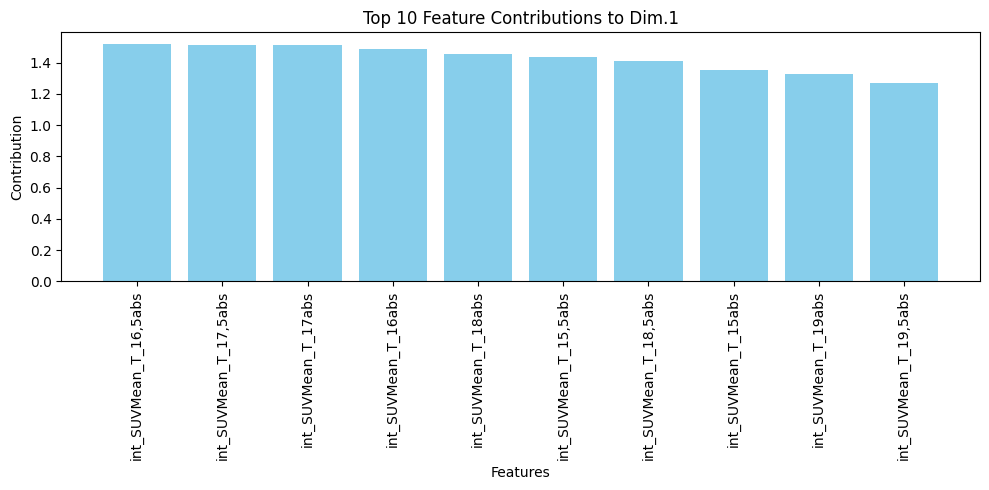

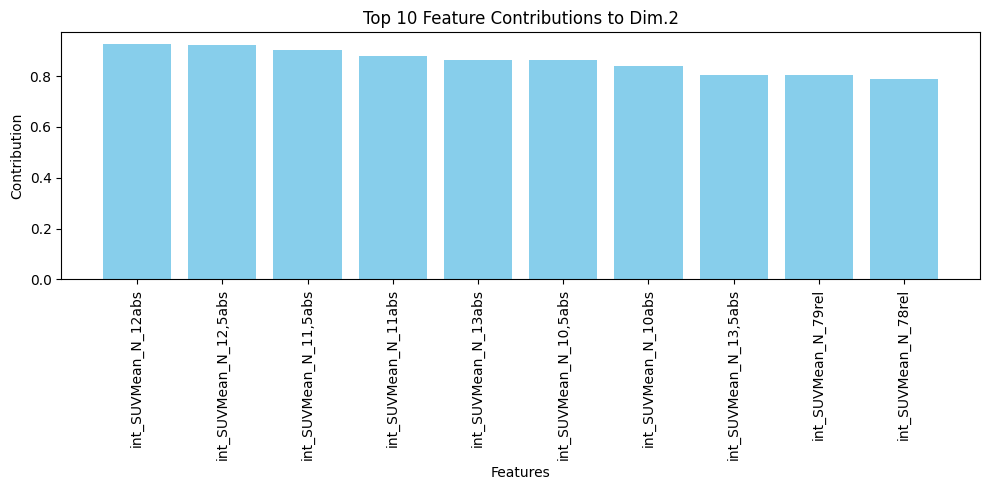

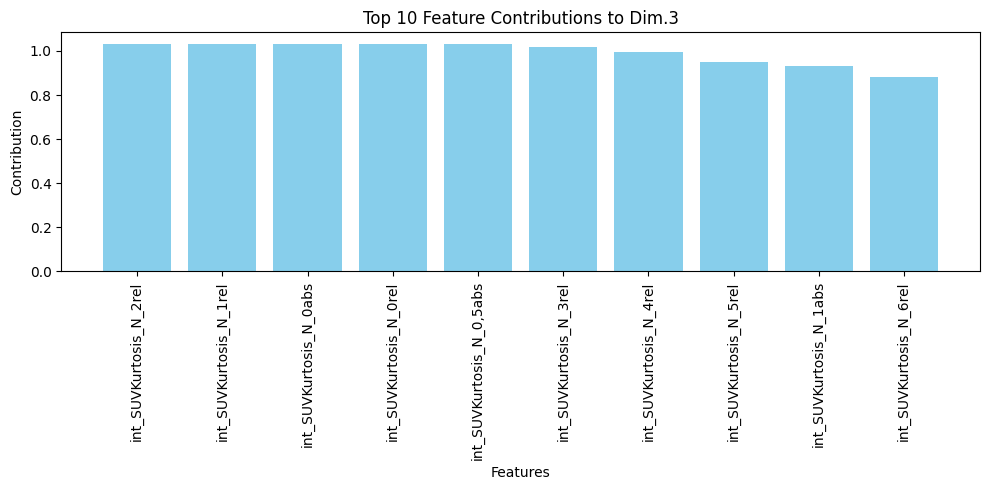

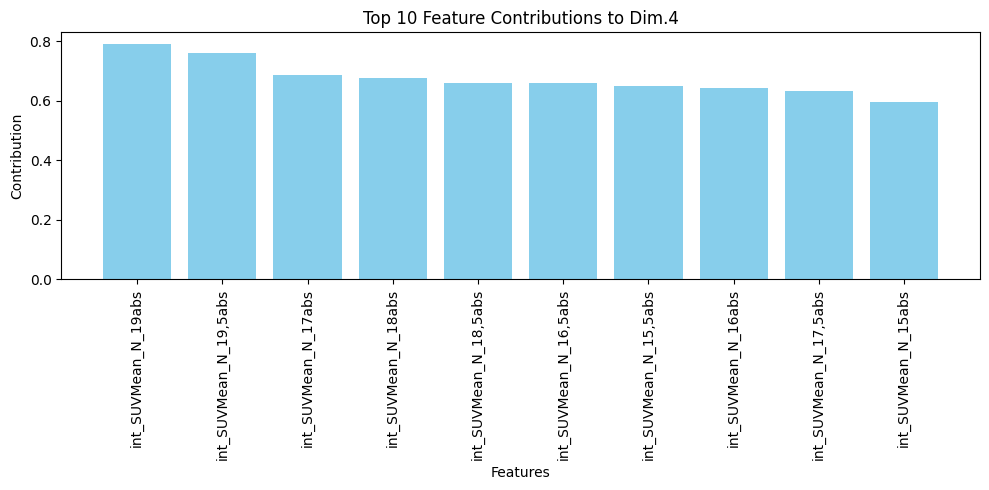

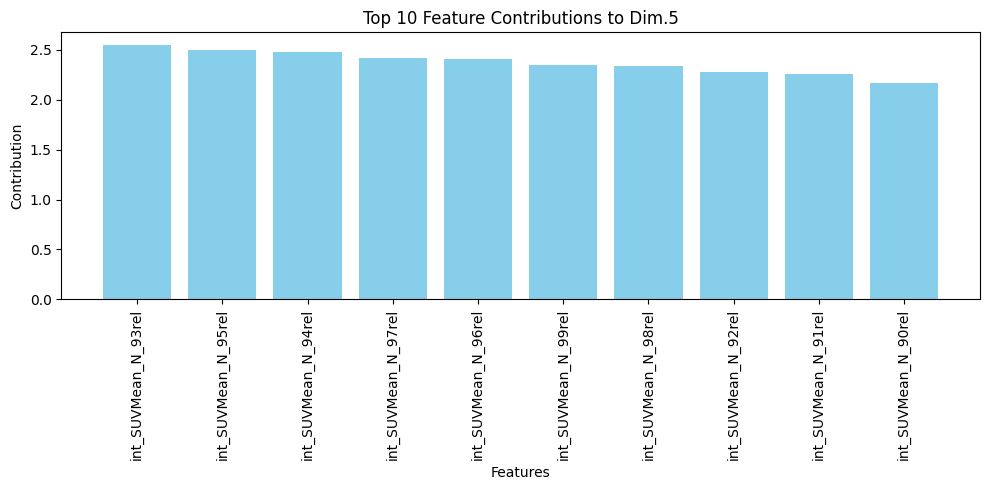

In [10]:
# List of dimensions (principal components) to plot (first 5 components)
dimensions = ['Dim.1', 'Dim.2', 'Dim.3', 'Dim.4', 'Dim.5']

# Function to plot top feature contributions for each PCA dimension
def plot_top_contributors(data, dimension, top_n=10):
    # Sort contributions by the specified dimension and select the top N contributors
    top_contributors = data[['Unnamed: 0', dimension]].sort_values(by=dimension, ascending=False).head(top_n)

    # Create bar plot
    plt.figure(figsize=(10, 5))
    plt.bar(top_contributors['Unnamed: 0'], top_contributors[dimension], color='skyblue')
    plt.title(f'Top {top_n} Feature Contributions to {dimension}')
    plt.xlabel('Features')
    plt.ylabel('Contribution')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Loop over the first 5 principal components and plot the top features for each
for dim in dimensions:
    plot_top_contributors(contrib, dim, top_n=10)  # You can adjust top_n for how many features to show